In [189]:
!pip install nbresult matplotlib==3.5.3 matplotlib-inline==0.1.6 numpy==1.23.4 pandas seaborn==0.11.2 scipy

In [190]:
# Carregue os imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [191]:
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


In [192]:
# Vamos fazer o load dos dados na variável 'data'
data = pd.read_csv('/content/train.csv', index_col='Id')
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [193]:
# Vamos fazer o drop da coluna SalePrice

X = data.drop(columns=['SalePrice'])
y = data.SalePrice

X.shape, y.shape

((1460, 79), (1460,))

In [194]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [195]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()

In [196]:
feat_categorical_nunique.sum()

252

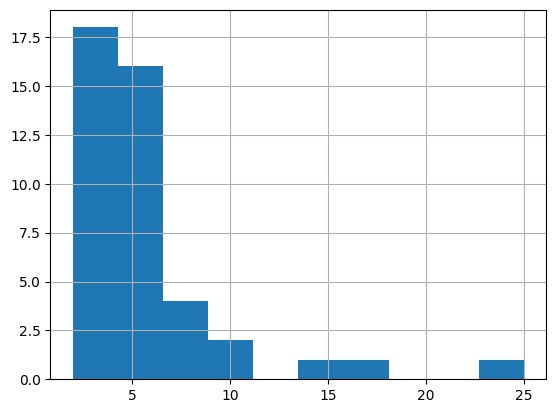

In [197]:
feat_categorical_nunique.hist();

In [198]:
# categorical features para one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)

In [199]:
# Quantidade de catgorias
len(feat_categorical_small)

34

In [200]:
!mkdir /content/tests




mkdir: cannot create directory ‘/content/tests’: File exists


In [201]:
!pip install --upgrade nbresult


In [202]:
from nbresult import ChallengeResult

# Seu código para definir e usar o ChallengeResult


In [203]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'features_overview',
    n=len(feat_categorical_small)
)

result.write()
result.check()

'\x1b======================================= test session starts ========================================\x1b\nplatform linux -- Python 3.10.12, pytest-7.4.3, pluggy-1.3.0 -- /usr/bin/python3\ncachedir: .pytest_cache\nrootdir: /content/tests\nplugins: anyio-3.7.1\n\x1bcollecting ... \x1bcollected 0 items\n\n\x1b====================================== \x1bno tests ran\x1b\x1b in 0.02s\x1b\x1b =======================================\x1b\n'

In [204]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f52f49d23e0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [205]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 183)

In [206]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.3, pluggy-1.3.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/tests
plugins: anyio-3.7.1
collecting ... collected 0 items

====================================== no tests ran in 0.01s =======================================



In [207]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f52f49d23e0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [208]:
# OPTION 1: recode it all manually
def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)

    log_error = np.log(1+t) - np.log(1+p)

    return ((log_error**2).mean())**0.5

# This is our metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [209]:
# OPTION 2 - re-use Sklearn's "mean_squared_log_error"

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

In [210]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.21253385009993178

In [211]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,129000.0


In [212]:
# Exporte os resultados
results.to_csv("/content/test.csv", header=True, index=False)

In [213]:
from nbresult import ChallengeResult

tmp = pd.read_csv("/content/test.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.3, pluggy-1.3.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/tests
plugins: anyio-3.7.1
collecting ... collected 0 items

====================================== no tests ran in 0.01s =======================================



In [214]:
# Define uma ordem específica para as características
# Observação: se você alterar esta ordem, ela mudará a saída para .transform()
feature_A_sorted_values = ['bad', 'average', 'good']
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

In [215]:
feat_ordinal_dict = {
    # Considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex']
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [216]:
# Define características numéricas de uma vez por todas.

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [217]:
# Define características nominais para codificar one-hot como as restantes (não numéricas, não ordinais)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [218]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [219]:
pd.DataFrame(preproc.fit_transform(X,y)).head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [220]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f52fa0eddb0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x7f52fc97b9a0>))])

In [221]:
preproc.fit_transform(X, y).shape

(1460, 54)

In [222]:
preproc_transformer_multi = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector_multi = SelectFromModel(
    RandomForestRegressor(),
    threshold = "median", # drop all multivariate features lower than the median correlation
)

preproc_multi = make_pipeline(
    preproc_transformer_multi,
    preproc_selector_multi
)

preproc_multi

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f52fa4f6770>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='median'))])

In [223]:
def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop"
    )

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector
    )

    return preproc.fit_transform(X).shape[1]

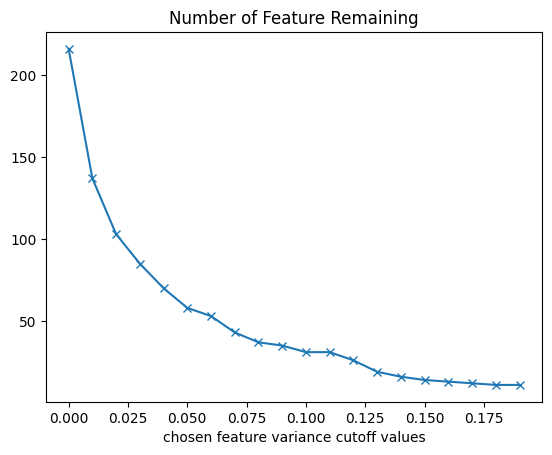

In [224]:
cutoff_values = np.arange(0, 0.2, 0.01)

plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')

plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");

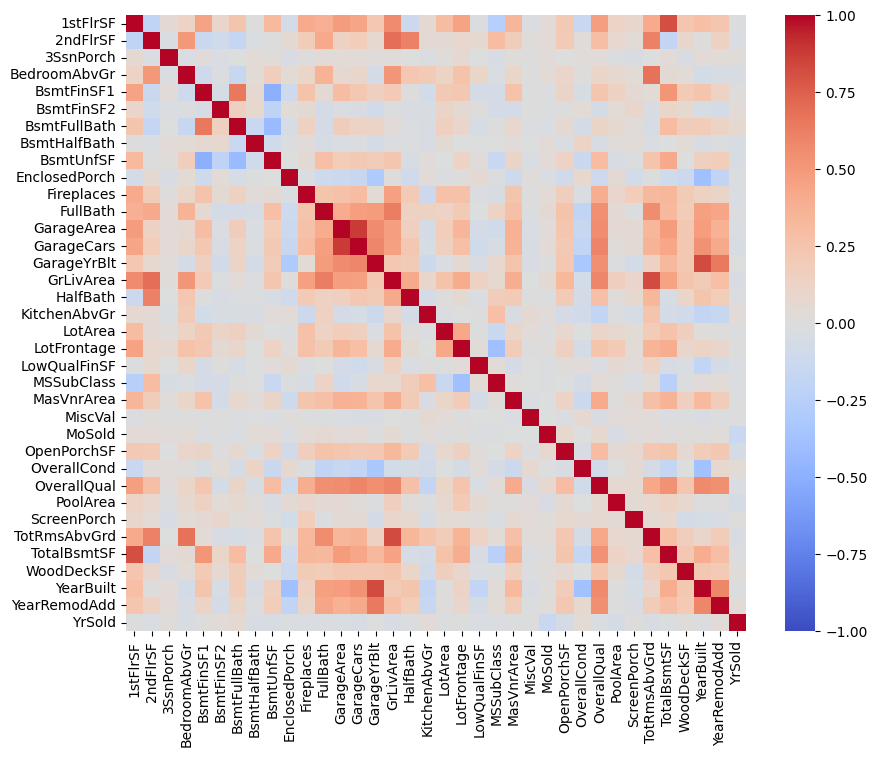

In [225]:
corr_num = X[feat_numerical].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [226]:
# Verifique quais colunas remover com base na alta correlação
num_corr_threshold = 0.95

corr_num = X[feat_numerical].corr()
corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool)).abs()

num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
num_col_to_drop

<ipython-input-226-e68989a4aecf>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool)).abs()


[]

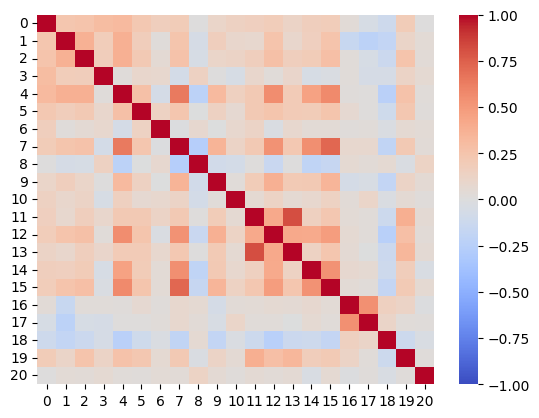

In [227]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))

sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1);

In [228]:
class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_corr_threshold=0.95):
        self.num_corr_threshold = num_corr_threshold

    def fit(self, X, y=None):
        feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

        corr_num = X[feat_numerical].corr()
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool)).abs()

        self.num_col_to_drop = [column for column in upper.columns if any(upper[column] > self.num_corr_threshold)]
        self.num_col = X[feat_numerical].columns

        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.num_col)

        return df.drop(columns=self.num_col_to_drop)

# Test it here
CustomFeatureSelector(num_corr_threshold=0.2).fit_transform(X[feat_numerical]).head(2)

<ipython-input-228-6c764f780ba8>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool)).abs()


,1stFlrSF,3SsnPorch,BsmtFinSF2,BsmtHalfBath,EnclosedPorch,KitchenAbvGr,LowQualFinSF,MiscVal,MoSold,ScreenPorch,YrSold
Id,,,,,,,,,,,
1,856,0,0,0,0,1,0,0,2,0,2008
2,1262,0,0,1,0,1,0,0,5,0,2007


In [229]:
# Tratar Características Cíclicas
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


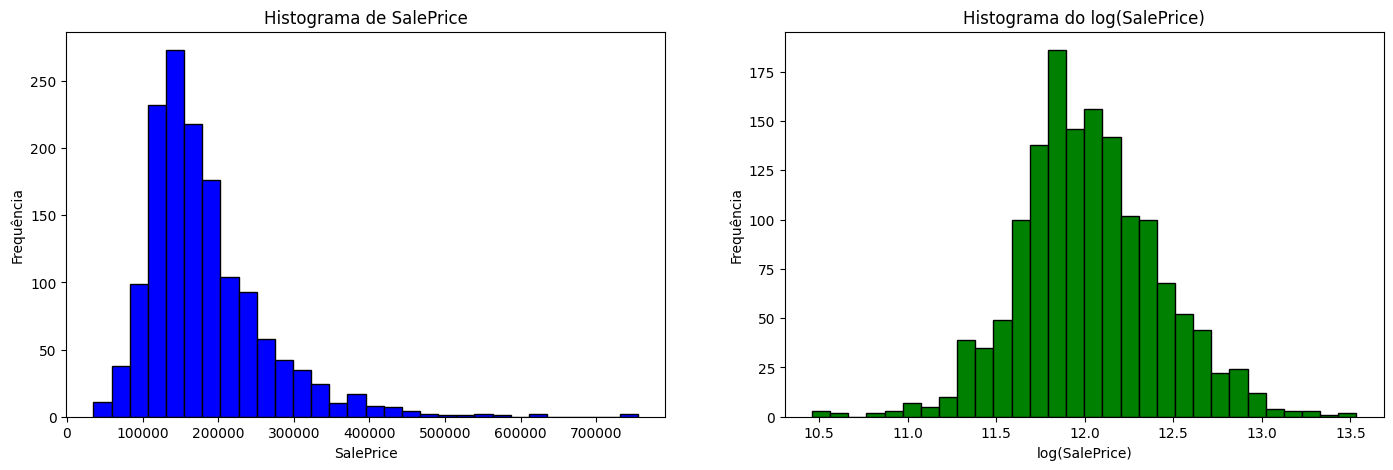

In [230]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

# Subplot para o histograma original
plt.subplot(1, 2, 1)
plt.hist(y, bins=30, color='blue', edgecolor='black')
plt.title('Histograma de SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequência')

# Subplot para o histograma dos dados transformados
plt.subplot(1, 2, 2)
plt.hist(y_log, bins=30, color='green', edgecolor='black')
plt.title('Histograma do log(SalePrice)')
plt.xlabel('log(SalePrice)')
plt.ylabel('Frequência')

plt.show()

In [231]:
# Crie seu novo marcador para minimizar
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Crie seu novo artilheiro para maximizar
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

In [232]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f52fa546530>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7f52fc97b9a0>))])

In [233]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)

preproc_fitted_log.transform(X).shape

(1460, 108)

In [234]:
# SOLUCAO
allow_grid_searching = True # Use True para ativar o GridSearch nas células do notebook abaixo

# Armazenar em cache a etapa de pré-processamento do pipeline
cachedir = mkdtemp()

In [235]:
# Ridge com normal target
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-209-034e749f6268>", line 4, in <lambda>
    rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 525, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

  warnings.warn(


nan

In [236]:
# Ridge com log-target (much better)
model = Ridge()

pipe_ridge = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()

0.13963773380245295

In [237]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5, 2, num=20)}

    search_ridge = GridSearchCV(
        pipe_ridge,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_ridge.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_ridge.best_params_}')
    print(f'Best score 👉 {search_ridge.best_score_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits

----------------------------------------

Best params 👉 {'ridge__alpha': 1.9210526315789473}
Best score 👉 -0.13912477766178177


In [238]:
model = KNeighborsRegressor()

pipe_knn = make_pipeline(preproc, model)

In [239]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()

0.2023276689862233

In [240]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}

    search_knn = GridSearchCV(
        pipe_knn,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_knn.fit(X, y_log);

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_knn.best_params_}')
    print(f'Best score 👉 {search_knn.best_score_}')

Fitting 3 folds for each of 11 candidates, totalling 33 fits

----------------------------------------

Best params 👉 {'kneighborsregressor__n_neighbors': 7}
Best score 👉 -0.203646118716814


In [241]:
model = SVR(kernel='linear')

pipe_svm = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

0.13764177458453886

In [242]:
model = SVR(kernel='rbf', C = 10)

pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)

cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

0.1359309843995193

In [243]:
# GridSearch
if allow_grid_searching:
    param_grid =  {
        'svr__C': [0.5, 0.7, 1, 2, 5, 10],
        'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
        #'svr__coef0': [0.0, 0.1, 0.5,1],
    }

    search_svm_rbf = GridSearchCV(
        pipe_svm_rbf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring=rmse_neg
    )

    search_svm_rbf.fit(X, y_log);

    svm_rbf_best = search_svm_rbf.best_estimator_

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_svm_rbf.best_params_}')
    print(f'Best score 👉 {search_svm_rbf.best_score_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits

----------------------------------------

Best params 👉 {'svr__C': 1, 'svr__epsilon': 0.01}
Best score 👉 -0.12682741544505455


In [244]:
model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

0.010026893027705654
0.1888994128962187


In [245]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

0.008636308275950933
0.1637348640245772


In [246]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.007653780684846304
0.14108475004968


In [247]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)

print(score.std())
print(score.mean())

0.00924414206979892
0.12794777856969972


In [248]:
min_features = int(0.9 * len(X.columns))
max_features = len(X.columns)

grid = {
    # outros parâmetros...
    'gradientboostingregressor__max_features': stats.randint(min_features, max_features)
}


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END gradientboostingregressor__max_features=72, gradientboostingregressor__n_estimators=138; total time=   1.0s
[CV] END gradientboostingregressor__max_features=72, gradientboostingregressor__n_estimators=138; total time=   1.0s
[CV] END gradientboostingregressor__max_features=72, gradientboostingregressor__n_estimators=138; total time=   1.0s
[CV] END gradientboostingregressor__max_features=72, gradientboostingregressor__n_estimators=138; total time=   1.0s
[CV] END gradientboostingregressor__max_features=72, gradientboostingregressor__n_estimators=138; total time=   1.0s
[CV] END gradientboostingregressor__max_features=75, gradientboostingregressor__n_estimators=220; total time=   1.4s
[CV] END gradientboostingregressor__max_features=75, gradientboostingregressor__n_estimators=220; total time=   1.4s
[CV] END gradientboostingregressor__max_features=75, gradientboostingregressor__n_estimators=220; total time=   1.6s
[CV]

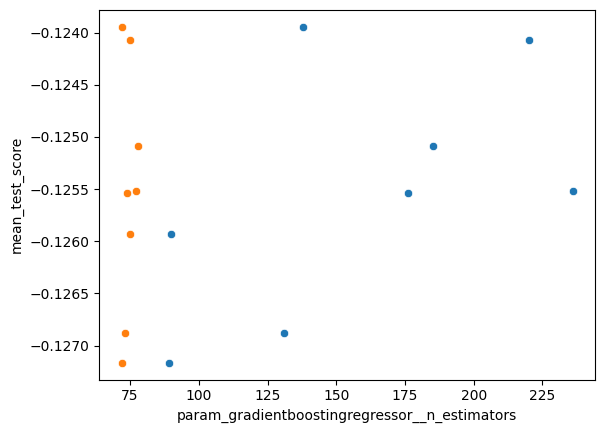

In [249]:
if allow_grid_searching:
    min_features = int(0.9 * len(X.columns))
    max_features = len(X.columns)

    grid = {
        'gradientboostingregressor__n_estimators': stats.randint(50, 300),
        # 'gradientboostingregressor__learning_rate': stats.uniform(0.05, 0.3),
        # 'gradientboostingregressor__loss': ['lad', 'huber', 'quantile'],
        # 'gradientboostingregressor__max_depth': stats.randint(3, 5),
        # 'gradientboostingregressor__min_samples_split': stats.randint(2, 10),
        # 'gradientboostingregressor__subsample': [0.95, 1],  # 1 default
        'gradientboostingregressor__max_features': stats.randint(min_features, max_features)
    }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2)

    # Fit data to GridSearch
    search_gb.fit(X, y_log)

    print('\n----------------------------------------\n')
    print(f'Best params 👉 {search_gb.best_params_}')
    print(f'Best score 👉 {search_gb.best_score_}')

    # Plot results of GridSearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)

    sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)


In [250]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    weights = [1, 1, 1, 1], # to equally weight the models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())

0.010452816958246791
0.12184835244698207


In [251]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost), ("adaboost", adaboost), ("ridge", ridge), ("svm_rbf", svm)],
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)

print(score.std())
print(score.mean())

0.010561279476739481
0.12124849574175353


In [252]:
# Cria um teste de avaliação apenas para fins de parada antecipada (XGBOOST e Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)

In [253]:
# Instanciar modelo
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)

In [254]:
# Opção 1: Integrar XGB ao pipeline do Sklearn
# Permite GridSearchCV seus melhores hiperparâmetros
pipe_xgb = make_pipeline(preproc, model_xgb)

cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()

0.14928856121049996

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Validation Score 0.1463160495379399


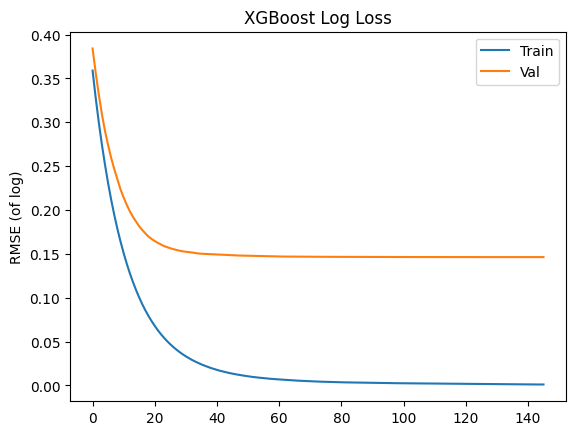

In [255]:
# Opção 2: Use a biblioteca XGBoost para ajustá-la
# Permite que você use um critério `early_stopping` com uma fenda Train/Val
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb.fit(
    X_train_preproc,
    y_train_log,
    verbose=False,
    eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
    eval_metric=["rmse"],
    early_stopping_rounds=10
)

# Retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# Plot RMSLE loss
fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))

In [266]:
X_test = pd.read_csv("/content/train.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

In [267]:
print(X_test.columns)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [268]:
# Verifique se 'MoSold' está presente (ignorando maiúsculas/minúsculas)
print('MoSold' in X_test.columns)


True


In [269]:
# Adicionando colunas ao X_test de acordo com o que fizemos no X
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test.drop(columns=['MoSold'], inplace=True)

In [270]:
pipe_stacking.fit(X, y_log)

predictions_log = pipe_stacking.predict(X_test)
predictions = np.exp(predictions_log)

In [271]:
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1,204438.068444
1,2,178135.001530
2,3,212968.782949
3,4,158038.889272
4,5,295087.579568
...,...,...
1455,1456,171458.589851
1456,1457,206051.952059
1457,1458,263241.287183
1458,1459,138636.609904


In [273]:
import os

# Specify the directory path
directory_path = "data"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Export the results to CSV
results.to_csv(os.path.join(directory_path, "submission_final.csv"), header=True, index=False)


## Compreensão do Desafio House Kaggle

O desafio House Prices tem como objetivo prever o preço de casas com base em diversas variáveis descritivas. O conjunto de dados inclui características como número de quartos, localização, ano de construção, entre outras. A métrica de avaliação usada é o erro médio quadrático logarítmico (RMSLE), que é comumente utilizado em problemas de regressão.

## Implementação das Soluções no Notebook Colab

Foram implementadas soluções utilizando técnicas e algoritmos de machine learning para realizar a previsão dos preços das casas. Algumas das abordagens incluíram modelos lineares, máquinas de vetores de suporte (SVM), árvores de decisão, florestas aleatórias, boosted trees, stacking, e o uso da biblioteca XGBoost.

## Utilização de Técnicas, Algoritmos e Bibliotecas

- **Modelos Lineares:** Ridge, Lasso, ElasticNet, SGDRegressor.
- **SVM com Kernel RBF:** Máquina de vetores de suporte com kernel radial.
- **Árvores e Florestas Aleatórias:** DecisionTreeRegressor, RandomForestRegressor.
- **Boosted Trees:** AdaBoostRegressor, GradientBoostingRegressor.
- **Stacking:** VotingRegressor, StackingRegressor.
- **XGBoost:** XGBRegressor.

Foram aplicadas técnicas de pré-processamento, como imputação de valores faltantes, normalização, e seleção de atributos. O treinamento dos modelos foi realizado utilizando pipelines para garantir a consistência e facilidade de replicação.

## Submissão ao Kaggle Open Challenge

Após o desenvolvimento e teste das soluções, os resultados foram submetidos ao Kaggle para avaliação. Foram seguidas as instruções do desafio para preparar os dados de teste e gerar as previsões, que foram então submetidas ao Kaggle para obtenção da pontuação final.

## Descrição dos Requisitos e Compreensão do Desafio

Os requisitos para o desenvolvimento incluíram:

1. Compreensão do conjunto de dados e do problema de previsão de preços das casas.
2. Implementação de algoritmos de regressão.
3. Uso de técnicas de pré-processamento de dados.
4. Avaliação de desempenho com métricas apropriadas.
5. Submissão das previsões ao Kaggle para avaliação externa.

A compreensão do desafio envolveu a análise detalhada do conjunto de dados, a escolha de modelos apropriados e a otimização dos hiperparâmetros para melhorar a precisão das previsões.

## Explicação Detalhada do Desenvolvimento

O código foi organizado em células e comentado de forma a facilitar a compreensão. Cada seção do notebook abordou um aspecto específico do desenvolvimento, desde o pré-processamento até a avaliação dos modelos. Comentários foram adicionados para explicar escolhas de implementação, ajustes de hiperparâmetros e resultados obtidos.

O processo de desenvolvimento seguiu boas práticas de ciência de dados, incluindo a exploração inicial do conjunto de dados, a manipulação cuidadosa dos dados, a escolha e treinamento de modelos, e a avaliação rigorosa do desempenho.
